In [2]:
import nest
import numpy as np
import numpy.ma as ma

from lsm.nest import LSM
from lsm.utils import poisson_generator

import matplotlib.pyplot as plot

# convention: all times in [ms], except stated otherwise


def generate_stimulus_xor(stim_times, gen_burst, n_inputs=2):
    inp_states = np.random.randint(2, size=(n_inputs, np.size(stim_times)))
    inp_spikes = []

    for times in ma.masked_values(inp_states, 0) * stim_times:
        # for each input (neuron): generate spikes according to state (=1) and stimulus time-grid
        spikes = np.concatenate([t + gen_burst() for t in times.compressed()])

        # round to simulation precision
        spikes *= 10
        spikes = spikes.round() + 1.0
        spikes = spikes / 10.0

        inp_spikes.append(spikes)

    # astype(int) could be omitted, because False/True has the same semantics
    targets = np.logical_xor(*inp_states).astype(int)
    print(inp_states.shape)
    return inp_spikes, targets


def generate_stimulus_olf(stim_times, gen_burst, n_inputs=2):
    inp_states = np.random.randint(2, size=(n_inputs, np.size(stim_times)))
    inp_spikes = []

    for times in ma.masked_values(inp_states, 0) * stim_times:
        # for each input (neuron): generate spikes according to state (=1) and stimulus time-grid
        spikes = np.concatenate([t + gen_burst() for t in times.compressed()])

        # round to simulation precision
        spikes *= 10
        spikes = spikes.round() + 1.0
        spikes = spikes / 10.0

        inp_spikes.append(spikes)

    # astype(int) could be omitted, because False/True has the same semantics
#     targets = inp_states[0]
    targets = np.logical_and(*inp_states).astype(int)
    bound = 5
    for i in range(len(targets)):
        if np.random.randint(1,bound)%bound-1 == 0:
            targets[i] = np.random.randint(0,2)
            
    print(inp_states.shape)
    return inp_spikes, targets


def inject_spikes(inp_spikes, neuron_targets):
    spike_generators = nest.Create("spike_generator", len(inp_spikes))

    for sg, sp in zip(spike_generators, inp_spikes):
        nest.SetStatus([sg], {'spike_times': sp})

    delay = dict(distribution='normal_clipped', mu=10., sigma=20., low=3., high=200.)
    C_inp = 100  # int(N_E / 20)  # number of outgoing input synapses per input neuron

    nest.Connect(spike_generators, neuron_targets,
                 {'rule': 'fixed_outdegree',
                  'outdegree': C_inp},
                 {'model': 'static_synapse',
                  'delay': delay,
                  'weight': {'distribution': 'uniform',
                             'low': 2.5 * 10 * 5.0,
                             'high': 7.5 * 10 * 5.0}
                  })


# nest.SetKernelStatus({'print_time': True, 'local_num_threads': 11})

In [2]:
sim_time = 200000

# stimulus
stim_interval = 300
stim_length = 50
stim_rate = 200  # [1/s]

readout_delay = 10

stim_times = np.arange(stim_interval, sim_time - stim_length - readout_delay, stim_interval)
readout_times = stim_times + stim_length + readout_delay

def gen_stimulus_pattern(): return poisson_generator(stim_rate, t_stop=stim_length)

inp_spikes, targets = generate_stimulus_olf(stim_times, gen_burst=gen_stimulus_pattern)

lsm = LSM(n_exc=1000, n_inh=250, n_rec=500)

inject_spikes(inp_spikes, lsm.inp_nodes)

# nest.SetKernelStatus({'print_time': True, 'local_num_threads': 11})

(2, 666)


In [3]:
inp, tar = generate_stimulus_xor(stim_times, gen_burst=gen_stimulus_pattern)
inp2, tar2 = generate_stimulus_olf(stim_times, gen_burst=gen_stimulus_pattern, n_inputs=3)

print(len(inp))
print(len(inp2))
print(inp[0].size)
print(inp2[0].size)
print(tar[0].size)
print(tar2[0].size)

# tar2
# 

(2, 666)
(3, 666)
2
3
3557
3242
1
1


In [4]:
nest.Simulate(sim_time)

In [5]:

readout_times = readout_times[5:]
targets = targets[5:]

states = lsm.get_states(readout_times, tau=20)

# add constant component to states for bias (TODO why?)
states = np.hstack([states, np.ones((np.size(states, 0), 1))])

n_examples = np.size(targets, 0)
n_examples_train = int(n_examples * 0.8)

train_states, test_states = states[:n_examples_train, :], states[n_examples_train:, :]
train_targets, test_targets = targets[:n_examples_train], targets[n_examples_train:]

readout_weights = lsm.compute_readout_weights(train_states, train_targets, reg_fact=5.0)

In [6]:
def classify(prediction):
    return (prediction >= 0.5).astype(int)

train_prediction = lsm.compute_prediction(train_states, readout_weights)
train_results = classify(train_prediction)

test_prediction = lsm.compute_prediction(test_states, readout_weights)
test_results = classify(test_prediction)

print("simulation time: {}ms".format(sim_time))
print("number of stimuli: {}".format(len(stim_times)))
print("size of each state: {}".format(np.size(states, 1)))

print("---------------------------------------")

def eval_prediction(prediction, targets, label):
    n_fails = sum(abs(prediction - targets))
    n_total = len(targets)
    print("mismatched {} examples: {:d}/{:d} [{:.1f}%]".format(label, n_fails, n_total, n_fails / n_total * 100))

eval_prediction(train_results, train_targets, "training")
eval_prediction(test_results, test_targets, "test")

simulation time: 200000ms
number of stimuli: 666
size of each state: 501
---------------------------------------
mismatched training examples: 2/528 [0.4%]
mismatched test examples: 32/133 [24.1%]


In [7]:
print(states.shape)
print(targets.shape)
print(test_states.shape)
print(test_targets.shape)
print(train_states.shape)
print(train_targets.shape)

(661, 501)
(661,)
(133, 501)
(133,)
(528, 501)
(528,)


In [8]:
print(targets.shape)


(661,)


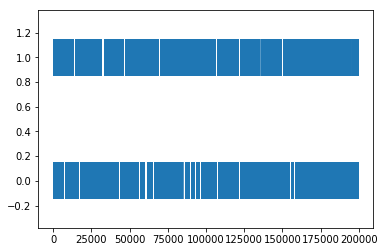

In [9]:
inp_spikes[0]
plot.eventplot(inp_spikes,linelengths=0.3)     
plot.show()

In [10]:
def generate_stimulus_noise(stim_times, gen_burst, n_inputs=2):
    inp_states = np.random.randint(2, size=(n_inputs, np.size(stim_times)))
    inp_spikes = []

    for times in ma.masked_values(inp_states, 0) * stim_times:
        # for each input (neuron): generate spikes according to state (=1) and stimulus time-grid
        spikes = np.concatenate([t + gen_burst() for t in times.compressed()])

        # round to simulation precision
        spikes *= 10
        spikes = spikes.round() + 1.0
        spikes = spikes / 10.0

        inp_spikes.append(spikes)

    # astype(int) could be omitted, because False/True has the same semantics
#     targets = np.logical_xor(*inp_states).astype(int)
    targets = np.random.randint(0,2,inp_states.size)
    return inp_spikes, targets

noise, noisyTarget = generate_stimulus_noise(stim_times, gen_burst=gen_stimulus_pattern)



# 

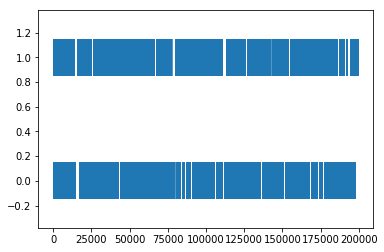

In [11]:
plot.eventplot(noise,linelengths=0.3)     
plot.show()

In [12]:
np.random.randint(0,2)

1

In [13]:
np.random.randint(0,2)

1

In [14]:
np.random.randint(1,5)

3



simulation time: 200000ms
number of stimuli: 666
size of each state: 501
---------------------------------------
mismatched training examples: 0/528 [0.0%]
mismatched test examples: 3/133 [2.3%]


bound = 20
5.3069999999999995
////


simulation time: 200000ms
number of stimuli: 666
size of each state: 501
---------------------------------------
mismatched training examples: 6/528 [1.1%]
mismatched test examples: 21/133 [15.8%]


bound = 8
14.29

////

simulation time: 200000ms
number of stimuli: 666
size of each state: 501
---------------------------------------
mismatched training examples: 2/528 [0.4%]
mismatched test examples: 32/133 [24.1%]



bound = 5


///////

if np.random.randint(1,5)%4 == 0:

simulation time: 200000ms
number of stimuli: 666
size of each state: 501
---------------------------------------
mismatched training examples: 10/528 [1.9%]
mismatched test examples: 38/133 [28.6%]

25.135999999999996

//////

bound = 4 

simulation time: 200000ms
number of stimuli: 666
size of each state: 501
---------------------------------------
mismatched training examples: 14/528 [2.7%]
mismatched test examples: 31/133 [23.3%]



////
if np.random.randint(1,3)%2 == 0:

bound = 3



simulation time: 200000ms
number of stimuli: 666
size of each state: 501
---------------------------------------
mismatched training examples: 183/528 [34.7%]
mismatched test examples: 49/133 [36.8%]

49.983

///////


In [3]:
count = 0
trials = 100000
bound = 5
for i in range(trials):
    if np.random.randint(1,bound)%bound -1 == 0:
        count += 1
        
print(count/trials * 100)

25.178


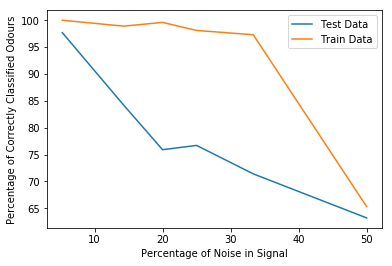

In [29]:
noise = [20,8,6,5,4,3]
test = [2.3,15.8,24.1,23.3,28.6,36.8]
train = [0.0,1.1,0.4,1.9,2.7,34.7]
noise = [1/(i-1)*100 for i in noise]
test = [100 - i for i in test]
train = [100 - i for i in train]

plot.plot(noise,test)
plot.plot(noise,train)
plot.legend(["Test Data","Train Data"])
plot.xlabel("Percentage of Noise in Signal")
plot.ylabel("Percentage of Correctly Classified Odours")
plot.show()






In [20]:
# per = (1./noise* 100)
noise = [1/i for i in noise]
